In [2]:
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
import scipy.interpolate
from scipy.interpolate import interp1d as interp1d


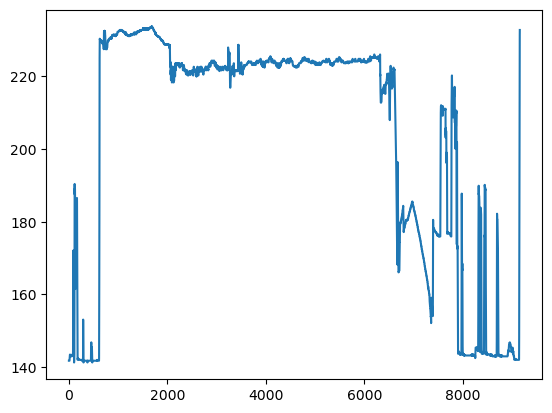

In [3]:
N22 = loadmat('../data/N22.mat')['N22'].squeeze()
plt.plot(N22)

In [4]:
N22.shape


(9160,)

In [5]:
N22.dtype

dtype('<f8')

In [6]:
type(N22)

numpy.ndarray

In [7]:
fs = 1000/10
old_grid = np.arange(N22.shape[0])
new_grid = np.linspace(0,  N22.shape[0], num=int(fs*N22.shape[0]))
new_grid = new_grid[new_grid<=old_grid[-1]]

In [8]:
f = interp1d(x=old_grid, y=N22, kind='cubic', axis=-1, copy=True, bounds_error=None, fill_value=None, assume_sorted=False)
f22 = f(new_grid)



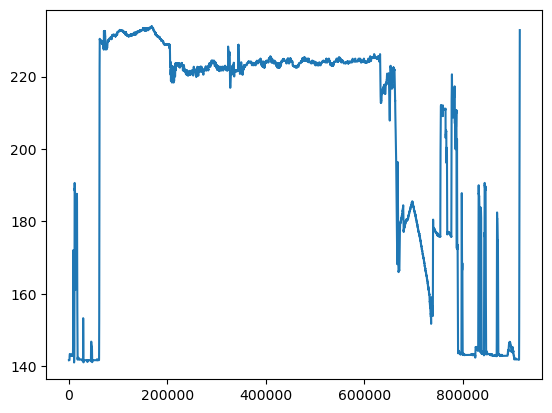

In [9]:
plt.plot(f22)

In [10]:
t1 = int(np.ceil(1.7*60*60*fs))
t2 = int(np.ceil(2*60*60*fs))

In [11]:
t1, t2, f22.shape

(612000, 720000, (915900,))

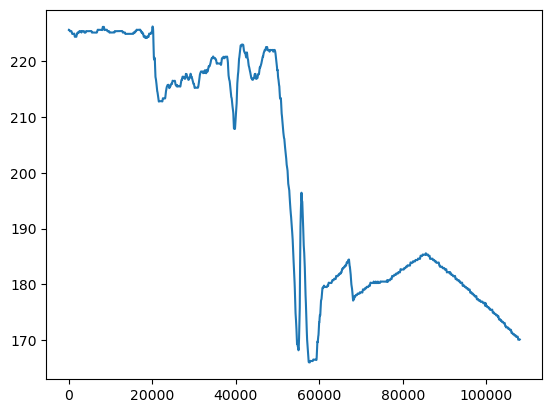

In [12]:
plt.plot(f22[t1:t2])

In [21]:
f22 = f22[t1:t2]

In [22]:
f22.shape

(108000,)

In [23]:
f = f22[38_000:60_000]

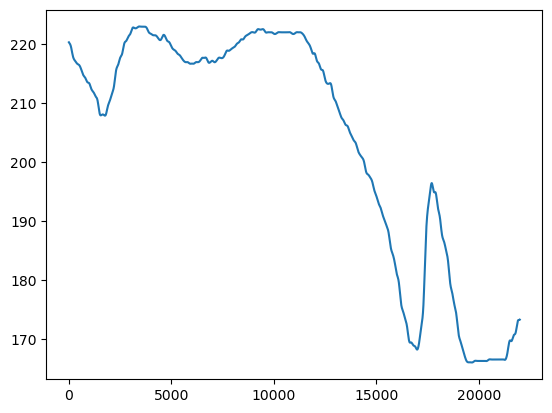

In [24]:
plt.plot(f)